# Implementação da yolo 

Esse notebook contém a implementação da yoloV2, uma versão mais antiga porém que ainda gera bons resultados em problemas de detecção de objetos em imagens. Para desenvolver o projeto tomei como base o código do repositorio https://github.com/experiencor/keras-yolo2 e usei o dataset cats and dog, que esta disponivel no https://www.kaggle.com/datasets/alvarole/asirra-cats-vs-dogs-object-detection-dataset. Objetivo do projeto era identificar e localizar cachorros e gatos nas imagens.  

In [1]:
from lxml import objectify
import glob
import os
import numpy as np
from utils.preprocessing import PreProcessing
from utils.generator import Generator
import matplotlib.pyplot as plt
import cv2 as cv

A classe 'PreProcessing' contém os métodos para extraçao dos labels e imagens dos diretórios que eles estão contidos.

In [2]:
pre_process = PreProcessing(dir_annotations='annotations',dir_images='images')

Aqui temos as configurações da rede:

    - size: padronizar o tamanho das imagens.
    - S: define a forma do grade.
    - N_bndBoxes: define a quantidade de bounding boxes que cada celula do grade irá ter.
    - num_anchor: define a quantidade de ancoras que usaremos para determinar seu bounding boxe.
    - f_x e f_y: escalares que definirão a posiçao dos bounding boxes no grade. 
   

In [3]:
SIZE=(224,224)
S=7
N_bndBoxes = 9
num_anchor=N_bndBoxes


f_x = SIZE[0]/S 
f_y = SIZE[1]/S


O metodo 'resize_dataset' padroniza as imagens para o tamanho especificado e também mapeia os bounding boxes para o novo tamanho

In [4]:
images, annotations = pre_process.resize_dataset(SIZE)

In [5]:
count_cat = 0
count_dog = 0

for sample in annotations:
    for label in sample['labels']:
        if label == 'cat':
            count_cat+=1
        elif label == 'dog':
            count_dog+=1
        
print('cat:',count_cat)
print('dog:',count_dog)


cat: 611
dog: 590
other: 0


# Dividindo em treino e teste

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(images),annotations,test_size=0.1)

In [8]:
X_train.shape

(989, 224, 224, 3)

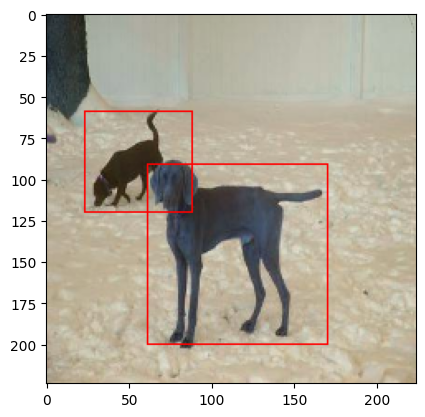

In [9]:
index = 5

img = X_train[index]
bnd_boxes = Y_train[index]['locations']
for bnd_boxe in bnd_boxes:
    img = cv.rectangle(img,(bnd_boxe[0],bnd_boxe[1]),(bnd_boxe[2],bnd_boxe[3]),(255,0,0),1)
plt.imshow(img)

# Construindo as grades

A yolo não uma CNN e sim uma FCN, ou seja, no final da rede não temos uma camada totalmente conectada mas uma camada convolucional. A saida da yolo é uma grade onde cada célula da grade contém um número espicífico de bounding boxes. O bouding boxe contém as infomações do centroide do bounding boxe (x,y) e a largura e altura do mesmo, uma posiçao que referencia a presença de um objeto chamado de objectness e a  quantidade classes, possuindo essa forma (4 + 1 + quantidade de classes) .Desse jeito, a saida da yolo tema seguinte forma SxSxN_bndBoxesx(4 + 1 + quantidade de classes). Para se aprofundar recomendo a leitura de https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088 e de  https://medium.com/analytics-vidhya/yolo-explained-5b6f4564f31. 

In [10]:
labels ={'cat':0,'dog':1}

In [11]:
len(labels)

2

In [12]:
generator = Generator()

As âncoras são bounding boxes com larguras e alturas pré definidas, cujo objetivo é determinar a posição do bounding boxes de acordo com a ancora que possui maior semelhança. Dessa forma a rede aprende um padrão de largura e altura que o bounding boxe pode ter. Elas são calculadas usadas com o conjunto de treino e geradas pelo algoritmo k-means, onde os clusters formam as âncoras. A similiraridade entre a ancora e o bounding boxe é definida pelo IoU (Intersections over union).    

In [13]:
anchors = generator.calculate_anchor(annotations=Y_train, num_anchor=num_anchor, size_image=SIZE, grid=(S,S)) 

In [14]:
anchors

array([[0.2416569 , 0.3686329 ],
       [0.36450066, 0.74152612],
       [0.54248271, 0.52311347],
       [0.87984913, 0.81554033],
       [0.921875  , 0.9484735 ],
       [0.50917207, 0.85129869],
       [0.7507485 , 0.91889435],
       [0.67767856, 0.79384398],
       [0.81759084, 0.62852443]])

In [15]:
Y_ = []


for sample in Y_train:
    grid = np.zeros((S,S,N_bndBoxes,4 + 1 + len(labels)))
    
    
   
    
    for label, location in zip(sample['labels'],sample['locations']):
        x = (location[0] + location[2])/2
        y = (location[1] + location[3])/2
        w = location[2] - location[0]
        h = location[3] - location[1]
        
        pos_x = int(x/f_x)
        pos_y = int(y/f_y)
        
        x_ = x/SIZE[0]
        y_ = y/SIZE[1]
        w_ = w/SIZE[0]
        h_ = h/SIZE[1]
        
        pos_box = -1
        max_iou = -1
        dim_bbox = [0,0,w_,h_]
        for i in range(anchors.shape[0]):
            anchor_bbox = [0,0,anchors[i][0],anchors[i][1]]
            iou = generator.calculate_IoU_bbox(dim_bbox,anchor_bbox)
            
            if iou > max_iou:
                pos_box = i
                max_iou = iou
       
        grid[pos_x,pos_y,pos_box,0:4]=[x_,y_,w_,h_]
        grid[pos_x,pos_y,pos_box,4]=1 #objectness
        grid[pos_x,pos_y,pos_box,labels[label]+5]=1
        
       
    
        
    Y_.append(grid)

In [16]:
Y_train = np.array(Y_)

In [17]:
Y_train.shape

(989, 7, 7, 9, 7)

In [18]:
Y_ = []


for sample in Y_test:
    grid = np.zeros((S,S,N_bndBoxes,4 + 1 + len(labels)))
    positions_of_objects = []
    
    
    
    for label, location in zip(sample['labels'],sample['locations']):
        x = (location[0] + location[2])/2
        y = (location[1] + location[3])/2
        w = location[2] - location[0]
        h = location[3] - location[1]
        
        pos_x = int(x/f_x)
        pos_y = int(y/f_y)
        
        x_ = x/SIZE[0]
        y_ = y/SIZE[1]
        w_ = w/SIZE[0]
        h_ = h/SIZE[1]
        
        pos_box = -1
        max_iou = -1
        dim_bbox = [0,0,w_,h_]
        for i in range(anchors.shape[0]):
            anchor_bbox = [0,0,anchors[i][0],anchors[i][1]]
            iou = generator.calculate_IoU_bbox(dim_bbox,anchor_bbox)
            
            if iou > max_iou:
                pos_box = i
                max_iou = iou
       
        grid[pos_x,pos_y,pos_box,0:4]=[x_,y_,w_,h_]
        grid[pos_x,pos_y,pos_box,4]=1 #objectness
        grid[pos_x,pos_y,pos_box,labels[label]+5]=1
        
        
    
      
    Y_.append(grid)

In [19]:
Y_test = np.array(Y_)

In [20]:
Y_test.shape

(110, 7, 7, 9, 7)

# Modelagem

O modelo utilizado se encontra melhor detalhado no repositório  https://github.com/experiencor/keras-yolo2. Além disso as camadas foram inicializados com os pesos da yolov2 ja treinada, com execeção da última camada.     

In [22]:
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Softmax, Conv2D, LeakyReLU, BatchNormalization, Input, MaxPooling2D, Flatten, Dense, Reshape, Activation, Lambda, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf


2022-12-30 07:52:29.270840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 07:52:29.840799: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-30 07:52:30.755846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/icaro/Projetos/Cats_Dogs/env/lib/python3.10/site-packages/cv2/../../lib64::/usr/local/cuda-11.7/lib64
2022-12-30 07:52:30.755997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [23]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x,block_size=2)

In [24]:
tensorboard = TensorBoard(log_dir=os.path.join(os.getcwd(),'logs'), histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_iou_bounding_Box',min_delta=0,patience=65,mode='max', restore_best_weights=True)

In [25]:
input_img = Input(shape=(X_train.shape[1:]))

#layer 1
conv = Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_1')(input_img)
BN = BatchNormalization(name='norma_1')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_1')(BN)
pool = MaxPooling2D(pool_size=[2,2])(LR)


#layer 2
conv = Conv2D(64,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_2')(pool)
BN = BatchNormalization(name='norma_2')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_2')(BN)
pool = MaxPooling2D(pool_size=[2,2])(LR)


#layer 3
conv = Conv2D(128,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_3')(pool)
BN = BatchNormalization(name='norma_3')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_3')(BN)


#layer 4
conv = Conv2D(64,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_4')(LR)
BN = BatchNormalization(name='norma_4')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_4')(BN)


#layer 5
conv = Conv2D(128,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_5')(LR)
BN = BatchNormalization(name='norma_5')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_5')(BN)
pool = MaxPooling2D(pool_size=[2,2])(LR)


#layer 6
conv = Conv2D(256,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_6')(pool)
BN = BatchNormalization(name='norma_6')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_6')(BN)


#layer 7
conv = Conv2D(128,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_7')(LR)
BN = BatchNormalization(name='norma_7')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_7')(BN)


#layer 8
conv = Conv2D(256,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_8')(LR)
BN = BatchNormalization(name='norma_8')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_8')(BN)
pool = MaxPooling2D(pool_size=[2,2])(LR)


#layer 9
conv = Conv2D(512,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_9')(pool)
BN = BatchNormalization(name='norma_9')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_9')(BN)


#layer 10
conv = Conv2D(256,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_10')(LR)
BN = BatchNormalization(name='norma_10')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_10')(BN)


#layer 11
conv = Conv2D(512,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_11')(LR)
BN = BatchNormalization(name='norma_11')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_11')(BN)


#layer 12
conv = Conv2D(256,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_12')(LR)
BN = BatchNormalization(name='norma_12')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_12')(BN)


#layer 13
conv = Conv2D(512,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_13')(LR)
BN = BatchNormalization(name='norma_13')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_13')(BN)


skip_connect =  LR

pool = MaxPooling2D(pool_size=(2,2))(LR)


# layer 14
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_14')(pool)
BN = BatchNormalization(name='norma_14')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_14')(BN)


# layer 15
conv = Conv2D(512,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_15')(LR)
BN = BatchNormalization(name='norma_15')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_15')(BN)


# layer 16
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_16')(LR)
BN = BatchNormalization(name='norma_16')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_16')(BN)


# layer 17
conv = Conv2D(512,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_17')(LR)
BN = BatchNormalization(name='norma_17')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_17')(BN)


# layer 18
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_18')(LR)
BN = BatchNormalization(name='norma_18')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_18')(BN)



# layer 19
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_19')(LR)
BN = BatchNormalization(name='norma_19')(conv)
LR = LeakyReLU(alpha = 0.1, name = 'LR_19')(BN)


# layer 20
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_20')(LR)
BN = BatchNormalization(name='norma_20')(conv)
res = LeakyReLU(alpha = 0.1, name = 'LR_20')(BN)


# layer 21
skip_connect = Conv2D(64,kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False, name='conv_21')(skip_connect)
skip_connect = BatchNormalization(name='norma_21')(skip_connect)
skip_connect = LeakyReLU(alpha = 0.1, name = 'LR_21')(skip_connect)
skip_connect = Lambda(space_to_depth_x2)(skip_connect)

res = concatenate([skip_connect,res])

#layer 22
conv = Conv2D(1024,kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False, name='conv_22')(res)
BN = BatchNormalization(name='norma_22')(conv)
res = LeakyReLU(alpha = 0.1, name = 'LR_22')(BN)

# layer 23
res = Conv2D(7*N_bndBoxes, kernel_size=(1,1), strides=(1,1), padding='same',use_bias=False, name='conv_23')(res)
output = Reshape((S,S,N_bndBoxes,7))(res)



model = Model(input_img,output)


2022-12-30 07:52:34.513679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 07:52:34.618916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 07:52:34.619128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 07:52:34.620241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 224, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norma_1 (BatchNormalization)   (None, 224, 224, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [27]:
class weights_reads(object):
    def __init__(self,file):
        self.weigths = np.fromfile(file, dtype='float32')
        self.offset = 4
        
    def read_weights(self,size):
        self.offset = self.offset + size
        return self.weigths[self.offset - size:self.offset]
    
    def reset(self):
        self.oofset=4
    

In [28]:
n_conv = 23
wr = weights_reads('yolov2.weights')

for n in range(1,n_conv+1):
   
    layer_conv = model.get_layer('conv_'+str(n))

    if i < n_conv:
        norm_layer = model.get_layer('norma_'+str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta =  wr.read_weights(size)
        gamma = wr.read_weights(size)
        mean = wr.read_weights(size)
        var = wr.read_weights(size)

        weights = norm_layer.set_weights([beta, gamma, mean, var])

        if len(layer_conv.get_weights()) > 1:
            bias = wr.read_weights(np.prod(layer_conv.get_weights()[1].shape))
            kernel = wr.read_weights(np.prod(layer_conv.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(layer_conv.get_weights()[0].shape))) 
            kernel = kernel.transpose([2,3,1,0])

            layer_conv = layer_conv.set_weights([kernel, bias])

        else:
            kernel = wr.read_weights(np.prod(layer_conv.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(layer_conv.get_weights()[0].shape))) 
            kernel = kernel.transpose([2,3,1,0])

            layer_conv = layer_conv.set_weights([kernel])
   

In [29]:
layer = model.get_layer('conv_23')
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(S*S)

layer.set_weights([new_kernel])

A função que mede o erro da yolo deve considerar 3 aspectos: o erro de localização, o erro de classificação e a confiança. Ela é calculada pelo somatorio do quadrado da difença entre o valor real e o valor predito. Obedecendo a seguinte fórmula: 

\begin{equation}
loss_{localização} = \frac{\lambda_{coord}}{N_{obj}} \sum_{i=0}^{S²}\sum_{j=0}^{B}L_{ij}^{obj}[(x_{ij} - \hat{x}_{ij})² + (y_{ij} - \hat{y}_{ij})] +  \frac{\lambda_{coord}}{N_{obj}} \sum_{i=0}^{S²}\sum_{j=0}^{B}L_{ij}^{obj}[(\sqrt{w_{ij}} - \sqrt{\hat{w}_{ij}})² + ( \sqrt{h_{ij}} - \sqrt{\hat{y}_{ij})}²]
\end{equation}

\begin{equation}
loss_{confiança} = \frac{\lambda_{obj}}{N_{conf}} \sum_{i=0}^{S²}\sum_{j=0}^{B}L_{ij}^{obj}[(C_{ij} - \hat{C}_{ij})²] +  \frac{\lambda_{noobj}}{N_{conf}} \sum_{i=0}^{S²}\sum_{j=0}^{B}L_{ij}^{noobj}[(0 - \hat{C}_{ij})²]
\end{equation}

\begin{equation}
loss_{classe} = \frac{\lambda_{class}}{N_{obj}} \sum_{i=0}^{S²} \sum_{j=0}^{B}L_{ij}^{obj} \sum_{c \epsilon class}^{class}(p(c) - p(\hat{c})
\end{equation}

\begin{equation}
loss = loss_{localização} + loss_{confiança} + loss_{classe}
\end{equation}

Para mais informações, recomenda-se ler o texto do link: https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html 



In [30]:
def custom_loss(y_true,y_pred):
    
        lambda_coord = 1.0
        lambda_class = 1.0
        lambda_obj = 5.0
        lambda_no_obj = 0.5
        
        
       
        
        """
        adjust_prediction
        """
        # adjust x and y
        pred_box_xy = y_pred[...,:2] 

        # adjust w and h 
        pred_box_wh = y_pred[...,2:4]

        # adjust conf
        pred_box_conf = y_pred[...,4]

        # adjust class
        pred_box_class = y_pred[...,5:]
        
        """
        adjust true
        """
        # adjust x e y
        true_box_xy = y_true[...,:2] 
        # adjust w e h
        true_box_wh = y_true[...,2:4] 

        # adjust confiance
        true_wh_half = true_box_wh / 2
        true_mins = true_box_xy - true_wh_half
        true_maxes = true_box_xy + true_wh_half

        pred_wh_half = pred_box_wh / 2
        pred_mins = pred_box_xy - pred_wh_half
        pred_maxes = pred_box_xy + pred_wh_half

        intersect_min = tf.maximum(pred_mins, true_mins)
        intersect_max = tf.minimum(pred_maxes, true_maxes)
        intersect_wh = tf.maximum(intersect_max-intersect_min,0)

        intersect_areas = intersect_wh[...,0] * intersect_wh[...,1]

        trues_areas = true_box_wh[...,0]*true_box_wh[...,1]
        pred_areas = pred_box_wh[...,0] * pred_box_wh[...,1]

        union_areas = trues_areas + pred_areas - intersect_areas

        iou_scores = tf.truediv(intersect_areas,union_areas)
        
        true_box_conf = y_true[...,4]*iou_scores

        # adjust class

        true_class = tf.argmax(y_true[...,5:],-1)
        
        '''
        adjust mask
        '''

        
        #L e N
        L_obj =  tf.cast(y_true[...,4]==1, tf.float32)
        N_obj = tf.reduce_sum(L_obj)
        
       
        
        L_no_obj = tf.cast(y_true[...,4] == 0,tf.float32)
        
        N_conf = tf.reduce_sum(L_obj + (L_no_obj*(1-L_obj)))
        
        L_obj_coord = tf.expand_dims(L_obj,axis=-1)
        
        
        
        loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)*L_obj_coord)*lambda_coord / (N_obj + 1e-6)  
        loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh)*L_obj_coord)*lambda_coord / (N_obj + 1e-6) 
        loss_conf = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf)*L_obj)*lambda_obj / (N_conf  + 1e-6) 
        loss_conf_no = tf.reduce_sum(tf.square(0 - pred_box_conf)* L_no_obj)*lambda_no_obj / (N_conf + 1e-6) 
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_class, logits=pred_box_class) 
        loss_class = tf.reduce_sum(loss_class*L_obj) / (N_obj  + 1e-6)

        loss = loss_xy + loss_wh  + loss_conf + loss_conf_no   + loss_class

        return loss

In [31]:
def iou_bounding_Box(y_true, y_pred):
    # adjust x and y
    pred_box_xy = y_pred[...,:2] #+ cell_grid

    # adjust w and h 
    pred_box_wh = y_pred[...,2:4]# * np.reshape(anchors,[1,1,1,N_bndBoxes,2])
    
     # adjust x e y
    true_box_xy = y_true[...,:2] 
        # adjust w e h
    true_box_wh = y_true[...,2:4] 
    
    
     # adjust confiance
    true_wh_half = true_box_wh / 2
    true_mins = true_box_xy - true_wh_half
    true_maxes = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2
    pred_mins = pred_box_xy - pred_wh_half
    pred_maxes = pred_box_xy + pred_wh_half

    intersect_min = tf.maximum(pred_mins, true_mins)
    intersect_max = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_max-intersect_min,0)

    intersect_areas = intersect_wh[...,0] * intersect_wh[...,1]

    trues_areas = true_box_wh[...,0]*true_box_wh[...,1]
    pred_areas = pred_box_wh[...,0] * pred_box_wh[...,1]

    union_areas = trues_areas + pred_areas - intersect_areas

    iou_scores = tf.truediv(intersect_areas,union_areas)
    iou_scores = iou_scores*y_true[...,4]
    qt = tf.reduce_sum(y_true[...,4])
    iou_mean = tf.reduce_sum(iou_scores)/ qt
    
    return iou_mean
    

In [32]:
model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=[iou_bounding_Box])
EPOCHS = 100
BATCH_SIZE = 15

In [33]:
history = model.fit(X_train,Y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.1,
                    callbacks= [early_stopping,tensorboard])

Epoch 1/100


2022-12-30 07:53:01.175029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-12-30 07:53:03.114981: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-30 07:53:03.115025: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-30 07:53:03.129732: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

60/60 [==============================] - 34s 444ms/step - loss: 0.9523 - iou_bounding_Box: 0.5085 - val_loss: 0.8110 - val_iou_bounding_Box: 0.5525
Epoch 2/100
60/60 [==============================] - 23s 387ms/step - loss: 0.7601 - iou_bounding_Box: 0.6478 - val_loss: 0.8071 - val_iou_bounding_Box: 0.5487
Epoch 3/100
60/60 [==============================] - 23s 389ms/step - loss: 0.7273 - iou_bounding_Box: 0.6581 - val_loss: 0.8473 - val_iou_bounding_Box: 0.5013
Epoch 4/100
60/60 [==============================] - 23s 391ms/step - loss: 0.6981 - iou_bounding_Box: 0.6588 - val_loss: 1.0731 - val_iou_bounding_Box: 0.5859
Epoch 5/100
60/60 [==============================] - 24s 393ms/step - loss: 0.6498 - iou_bounding_Box: 0.6440 - val_loss: 1.2146 - val_iou_bounding_Box: 0.4988
Epoch 6/100
60/60 [==============================] - 25s 412ms/step - loss: 0.6006 - iou_bounding_Box: 0.6598 - val_loss: 0.9639 - val_iou_bounding_Box: 0.5394
Epoch 7/100
60/60 [==============================] -

In [34]:
with tf.device('CPU'):
    Y_pred = model.evaluate(X_test,Y_test)

4/4 [==============================] - 4s 907ms/step - loss: 1.2249 - iou_bounding_Box: 0.6871


In [35]:
with tf.device('CPU'):
    Y_pred = model.predict(X_test)

4/4 [==============================] - 4s 887ms/step


In [36]:
def custom_loss_predictions(y_true,y_pred):
        mask_shape = y_true.shape[:4]

        cell_x = tf.cast(tf.reshape(tf.tile(tf.range(S),[S]),(1,S,S,1,1)),tf.float32)
        cell_y = tf.transpose(cell_x,(0,2,1,3,4))

        cell_grid = tf.tile(tf.concat([cell_x,cell_y],-1),[BATCH_SIZE,1,1,9,1])
        
        conf_mask = tf.zeros(shape=mask_shape)
       
        """
        adjust_prediction
        """
        # adjust x and y
        pred_box_xy = y_pred[...,:2] #+ cell_grid

        # adjust w and h 
        pred_box_wh = y_pred[...,2:4] #* np.reshape(anchors,[1,1,1,N_bndBoxes,2])

        # adjust conf
        pred_box_conf = y_pred[...,4]

        # adjust class
        pred_box_class = y_pred[...,5:]


        """
        adjust true
        """
        # adjust x e y
        true_box_xy = y_true[...,:2]
        # adjust w e h
        true_box_wh = y_true[...,2:4]

        # adjust confiance
        true_wh_half = true_box_wh / 2
        true_mins = true_box_xy - true_wh_half
        true_maxes = true_box_xy + true_wh_half

        pred_wh_half = pred_box_wh / 2
        pred_mins = pred_box_xy - pred_wh_half
        pred_maxes = pred_box_xy + pred_wh_half

        intersect_min = tf.maximum(pred_mins, true_mins)
        intersect_max = tf.minimum(pred_maxes, true_maxes)
        intersect_wh = tf.maximum(intersect_max-intersect_min,0)

        intersect_areas = intersect_wh[...,0] * intersect_wh[...,1]

        trues_areas = true_box_wh[...,0]*true_box_wh[...,1]
        pred_areas = pred_box_wh[...,0] * pred_box_wh[...,1]

        union_areas = trues_areas + pred_areas - intersect_areas

        iou_scores = tf.truediv(intersect_areas,union_areas)

        true_box_conf = y_true[...,4] * iou_scores

        # adjust class

        true_class = tf.argmax(y_true[...,5:],-1)

        L_obj =  tf.cast(y_true[...,4]==1, tf.float32)
        N_obj = tf.reduce_sum(L_obj)
        
        N_obj = tf.cast(N_obj, tf.float64)
       
        
        L_no_obj = tf.cast(iou_scores < 0.6,tf.float32)*tf.cast(y_true[...,4] == 0,tf.float32)
        
        N_conf = tf.reduce_sum(L_obj + (L_no_obj*(1-L_obj)))
        
        N_conf = tf.cast(N_conf, tf.float32)
        
        L_obj_coord = tf.expand_dims(L_obj,axis=-1)
        #conf_mask_obj = conf_mask_obj + tf.cast(iou_scores < 0.6,tf.float32)*(1-y_true[...,4])
        #conf_mask =  y_true[...,4]
        
        '''coord_mask = tf.expand_dims(y_true[...,4],axis=-1)
        class_mask = y_true[...,4]'''
        
       
        lambda_coord = 1.0
        lambda_class = 1.0
        lambda_obj = 5.0
        lambda_no_obj = 0.5
        
       
        pred_box_conf = pred_box_conf 
        
        loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)*tf.cast(L_obj_coord,tf.double))*lambda_coord / (N_obj + 1e-6)  
        loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh)*tf.cast(L_obj_coord,tf.double))*lambda_coord / (N_obj + 1e-6) 
        loss_conf = tf.reduce_sum(tf.square(true_box_conf  - pred_box_conf)*L_obj)*lambda_obj / (N_conf + 1e-6) 
        loss_conf_no = tf.reduce_sum(tf.cast(tf.square(0 - pred_box_conf),tf.double)* tf.cast(L_no_obj,tf.double))*lambda_no_obj / (tf.cast(N_conf,tf.float64) + 1e-6) 
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_class, logits=pred_box_class) 
        loss_class = tf.reduce_sum(tf.cast(loss_class,tf.double)*tf.cast(L_obj,tf.double))*lambda_class / (N_obj + 1e-6)


        loss = tf.cast(loss_xy,tf.double) + tf.cast(loss_wh,tf.double) + tf.cast(loss_conf,tf.double) + tf.cast(loss_conf_no,tf.double)  + tf.cast(loss_class,tf.double)

        print('loss_xy:',loss_xy)
        print('loss_wh:',loss_wh)
        print('loss_conf:',loss_conf)
        print('loss_no_conf:',loss_conf_no)
        print('loss_class:',loss_class)
        


In [37]:
custom_loss_predictions(Y_test,Y_pred)

loss_xy: tf.Tensor(0.004454360113819901, shape=(), dtype=float64)
loss_wh: tf.Tensor(0.042901238269034754, shape=(), dtype=float64)
loss_conf: tf.Tensor(0.0011960804, shape=(), dtype=float32)
loss_no_conf: tf.Tensor(0.0008082470616072726, shape=(), dtype=float64)
loss_class: tf.Tensor(1.1792820093068355, shape=(), dtype=float64)


In [44]:
images_objecst_pred = []
for sample in Y_pred:
    objects = []
    for cell_x in sample:
        for cell_y in cell_x:
            for bounding_box in cell_y:
                if bounding_box[4]>0.53:
                    objects.append(bounding_box)
    
    images_objecst_pred.append(objects)

In [45]:
count= 0
for obj in images_objecst_pred:
    count+=len(obj)
print(count)

115


In [46]:
images_objecst_test = []
for sample in Y_test:
    objects = []
    for cell_x in sample:
        for cell_y in cell_x:
            for bounding_box in cell_y:
                if bounding_box[4] == 1:
                    objects.append(bounding_box)
    
    images_objecst_test.append(objects)

In [47]:
count= 0
for obj in images_objecst_test:
    count+=len(obj)
print(count)

115


In [94]:
def convert_bounding_box(images_objects, size_images):
    images_objects_convert = []
    
    for sample in images_objects:
        result = {}
        obj_class = []
        obj_in_image = []
        for bouding_box in sample:
            x = bouding_box[0]
            y = bouding_box[1]
            w = bouding_box[2]
            h = bouding_box[3]
            
            x = x*size_images[0]
            y = y*size_images[1]
            w = w*size_images[0]
            h = h*size_images[1]
            
            w_half = w/2
            h_half = h/2
            
            xmin = int(x - w_half)
            xmax = int(x + w_half)
            
            ymin = int(y - h_half)
            ymax = int(y + h_half)
            
            location = [xmin,ymin,xmax,ymax]
            obj_in_image.append(location)
            obj_label = np.argmax(bouding_box[5:])
            
            
            if obj_label == 1:
                obj_class.append('dog')
            if obj_label == 0:
                obj_class.append('cat')
        
        
        result['locations'] = obj_in_image
        result['labels'] = obj_class
        
        images_objects_convert.append(result)
    
    return images_objects_convert
        

In [95]:
img_pred = convert_bounding_box(images_objecst_pred, SIZE)
img_test = convert_bounding_box(images_objecst_test, SIZE)

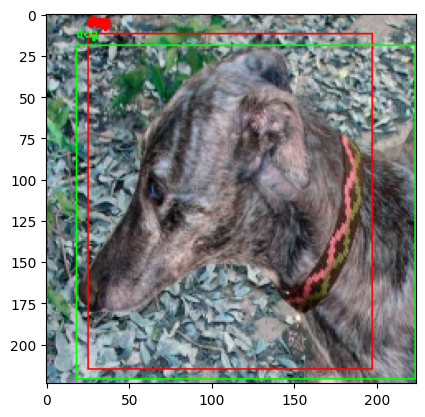

In [127]:
index = 25
img = X_test[index]
bnd_boxes_pred = img_pred[index]['locations']
bnd_boxes_test = img_test[index]['locations']

labels_pred = img_pred[index]['labels']
labels_test = img_test[index]['labels']

for bnd_boxe, label in zip(bnd_boxes_pred, labels_pred):
    img = cv.rectangle(img,(bnd_boxe[0],bnd_boxe[1]),(bnd_boxe[2],bnd_boxe[3]),(255,0,0),1)
    img = cv.putText(img,label,(bnd_boxe[0],bnd_boxe[1]-5), cv.FONT_HERSHEY_SIMPLEX,1e-3*img.shape[1],(255,0,0),2)
    
for bnd_boxe,label in zip(bnd_boxes_test,labels_test):
    img = cv.rectangle(img,(bnd_boxe[0],bnd_boxe[1]),(bnd_boxe[2],bnd_boxe[3]),(0,255,0),1)
    img = cv.putText(img,label,(bnd_boxe[0],bnd_boxe[1]-5), cv.FONT_HERSHEY_SIMPLEX,1e-3*img.shape[1],(0,255,0),1)

plt.imshow(img)


In [128]:
#cv.imwrite('dog.png',img)

True

In [115]:
generator.calculate_IoU_bbox(bnd_boxes_pred[0],bnd_boxes_test[0])

0.8466886024591178

In [52]:
iou = []

for true, pred in zip(img_test, img_pred):
    bbox_pred = pred['locations']
    bbox_true = true['locations']
    
    for index in range(len(bbox_true)):
        try:
            iou_sample = generator.calculate_IoU_bbox(bbox_pred[index],bbox_true[index])
            
            iou.append(iou_sample)
        except:
            iou_sample = generator.calculate_IoU_bbox([0,0,0,0],bbox_true[index])
            iou.append(iou_sample)
        
    
    


In [53]:
sum(iou)/len(iou)

0.6581318825713284

In [114]:
model.save('cats_and_dogs.h5',save_traces=model.get_config())

In [117]:
model_trained = tf.keras.models.load_model('cats_and_dogs',custom_objects={'iou_bounding_Box':iou_bounding_Box,
                                                                            'custom_loss':custom_loss })